In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_PATH = r'/kaggle/input/maldeb-dataset/debinew'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
full_dataset = datasets.ImageFolder(root=DATASET_PATH)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

In [13]:
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [15]:
print(f"Class mapping: {full_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Class mapping: {'Benign': 0, 'Malicious': 1}
Training samples: 16683
Validation samples: 4171


In [16]:
class MalwareClassifier(nn.Module):
    def __init__(self):
        super(MalwareClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [17]:
model = MalwareClassifier().to(DEVICE)
print(model)

MalwareClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplac

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(DEVICE), labels.float().to(DEVICE)
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    return running_loss / len(loader), 100 * correct / total, all_preds, all_labels


In [20]:
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience = 10
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_malware_model.pth')
        print(f"Model saved! Best Val Acc: {best_val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.load_state_dict(torch.load('best_malware_model.pth'))


Epoch 1/50


Validation: 100%|██████████| 131/131 [00:14<00:00,  8.87it/s, loss=0.159, acc=93.7] 


Train Loss: 0.2563, Train Acc: 89.79%
Val Loss: 0.1739, Val Acc: 93.72%
Model saved! Best Val Acc: 93.72%

Epoch 2/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.24it/s, loss=0.084, acc=96.2] 


Train Loss: 0.1495, Train Acc: 94.78%
Val Loss: 0.1163, Val Acc: 96.19%
Model saved! Best Val Acc: 96.19%

Epoch 3/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.49it/s, loss=0.0754, acc=96.9]


Train Loss: 0.1203, Train Acc: 95.71%
Val Loss: 0.0990, Val Acc: 96.93%
Model saved! Best Val Acc: 96.93%

Epoch 4/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.38it/s, loss=0.122, acc=94]   


Train Loss: 0.1066, Train Acc: 96.35%
Val Loss: 0.1520, Val Acc: 93.96%

Epoch 5/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.43it/s, loss=0.0297, acc=97.1]


Train Loss: 0.0890, Train Acc: 97.00%
Val Loss: 0.0978, Val Acc: 97.05%
Model saved! Best Val Acc: 97.05%

Epoch 6/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.32it/s, loss=0.107, acc=97.3] 


Train Loss: 0.0809, Train Acc: 97.22%
Val Loss: 0.0799, Val Acc: 97.31%
Model saved! Best Val Acc: 97.31%

Epoch 7/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.36it/s, loss=0.0989, acc=95.8]


Train Loss: 0.0694, Train Acc: 97.52%
Val Loss: 0.1325, Val Acc: 95.83%

Epoch 8/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.51it/s, loss=0.0269, acc=97.3]


Train Loss: 0.0676, Train Acc: 97.69%
Val Loss: 0.0907, Val Acc: 97.29%

Epoch 9/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.44it/s, loss=0.0365, acc=97.7] 


Train Loss: 0.0623, Train Acc: 97.87%
Val Loss: 0.0798, Val Acc: 97.70%
Model saved! Best Val Acc: 97.70%

Epoch 10/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.35it/s, loss=0.0207, acc=97.9] 


Train Loss: 0.0525, Train Acc: 98.19%
Val Loss: 0.0720, Val Acc: 97.94%
Model saved! Best Val Acc: 97.94%

Epoch 11/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.33it/s, loss=0.0994, acc=96.5]


Train Loss: 0.0509, Train Acc: 98.14%
Val Loss: 0.0954, Val Acc: 96.50%

Epoch 12/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.45it/s, loss=0.032, acc=97]    


Train Loss: 0.0449, Train Acc: 98.37%
Val Loss: 0.1135, Val Acc: 97.00%

Epoch 13/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.26it/s, loss=0.0504, acc=97.8] 


Train Loss: 0.0417, Train Acc: 98.46%
Val Loss: 0.0712, Val Acc: 97.77%

Epoch 14/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.46it/s, loss=0.0365, acc=97.9] 


Train Loss: 0.0390, Train Acc: 98.56%
Val Loss: 0.0783, Val Acc: 97.89%

Epoch 15/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.44it/s, loss=0.0858, acc=96.7] 


Train Loss: 0.0327, Train Acc: 98.95%
Val Loss: 0.1005, Val Acc: 96.69%

Epoch 16/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.32it/s, loss=0.0758, acc=97.4]  


Train Loss: 0.0306, Train Acc: 98.86%
Val Loss: 0.0809, Val Acc: 97.36%

Epoch 17/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.34it/s, loss=0.0395, acc=97.7]  


Train Loss: 0.0270, Train Acc: 99.07%
Val Loss: 0.1107, Val Acc: 97.67%

Epoch 18/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.53it/s, loss=0.0126, acc=98]   


Train Loss: 0.0288, Train Acc: 99.08%
Val Loss: 0.0711, Val Acc: 97.96%
Model saved! Best Val Acc: 97.96%

Epoch 19/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.56it/s, loss=0.00981, acc=98.1]


Train Loss: 0.0224, Train Acc: 99.14%
Val Loss: 0.0766, Val Acc: 98.13%
Model saved! Best Val Acc: 98.13%

Epoch 20/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.34it/s, loss=0.00442, acc=98]   


Train Loss: 0.0295, Train Acc: 99.19%
Val Loss: 0.0811, Val Acc: 98.01%

Epoch 21/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.37it/s, loss=0.0341, acc=98.3]  


Train Loss: 0.0233, Train Acc: 99.26%
Val Loss: 0.0789, Val Acc: 98.32%
Model saved! Best Val Acc: 98.32%

Epoch 22/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.37it/s, loss=0.0124, acc=97.5] 


Train Loss: 0.0147, Train Acc: 99.51%
Val Loss: 0.0874, Val Acc: 97.46%

Epoch 23/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.25it/s, loss=0.00369, acc=98.1] 


Train Loss: 0.0249, Train Acc: 99.16%
Val Loss: 0.0751, Val Acc: 98.08%

Epoch 24/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.39it/s, loss=0.0157, acc=98.2]  


Train Loss: 0.0200, Train Acc: 99.30%
Val Loss: 0.0700, Val Acc: 98.15%

Epoch 25/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.37it/s, loss=0.0253, acc=98.3]  


Train Loss: 0.0173, Train Acc: 99.41%
Val Loss: 0.0737, Val Acc: 98.35%
Model saved! Best Val Acc: 98.35%

Epoch 26/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.30it/s, loss=0.00323, acc=98.3] 


Train Loss: 0.0152, Train Acc: 99.53%
Val Loss: 0.1078, Val Acc: 98.30%

Epoch 27/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.42it/s, loss=0.00572, acc=98.4] 


Train Loss: 0.0141, Train Acc: 99.48%
Val Loss: 0.0999, Val Acc: 98.42%
Model saved! Best Val Acc: 98.42%

Epoch 28/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.51it/s, loss=0.00144, acc=98.2] 


Train Loss: 0.0140, Train Acc: 99.55%
Val Loss: 0.1045, Val Acc: 98.25%

Epoch 29/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.45it/s, loss=0.00881, acc=98.3] 


Train Loss: 0.0148, Train Acc: 99.55%
Val Loss: 0.1066, Val Acc: 98.30%

Epoch 30/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.47it/s, loss=0.089, acc=98.2]   


Train Loss: 0.0126, Train Acc: 99.54%
Val Loss: 0.1021, Val Acc: 98.25%

Epoch 31/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.15it/s, loss=0.0833, acc=98.5]  


Train Loss: 0.0082, Train Acc: 99.74%
Val Loss: 0.1042, Val Acc: 98.51%
Model saved! Best Val Acc: 98.51%

Epoch 32/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.45it/s, loss=0.0153, acc=98.4]  


Train Loss: 0.0091, Train Acc: 99.70%
Val Loss: 0.1049, Val Acc: 98.39%

Epoch 33/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.58it/s, loss=0.00238, acc=98.1] 


Train Loss: 0.0047, Train Acc: 99.87%
Val Loss: 0.0974, Val Acc: 98.08%

Epoch 34/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.46it/s, loss=0.00315, acc=98.3] 


Train Loss: 0.0056, Train Acc: 99.84%
Val Loss: 0.0928, Val Acc: 98.27%

Epoch 35/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.49it/s, loss=0.00146, acc=98.3] 


Train Loss: 0.0052, Train Acc: 99.83%
Val Loss: 0.0981, Val Acc: 98.32%

Epoch 36/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.44it/s, loss=0.0106, acc=98.2] 


Train Loss: 0.0039, Train Acc: 99.86%
Val Loss: 0.1258, Val Acc: 98.20%

Epoch 37/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.43it/s, loss=0.00535, acc=98.5] 


Train Loss: 0.0030, Train Acc: 99.90%
Val Loss: 0.1264, Val Acc: 98.51%

Epoch 38/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.56it/s, loss=0.011, acc=98.5]   


Train Loss: 0.0035, Train Acc: 99.88%
Val Loss: 0.1157, Val Acc: 98.54%
Model saved! Best Val Acc: 98.54%

Epoch 39/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.44it/s, loss=0.000421, acc=98.4]


Train Loss: 0.0023, Train Acc: 99.92%
Val Loss: 0.1336, Val Acc: 98.42%

Epoch 40/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.43it/s, loss=0.00124, acc=98.3] 


Train Loss: 0.0044, Train Acc: 99.89%
Val Loss: 0.1400, Val Acc: 98.35%

Epoch 41/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.48it/s, loss=0.0012, acc=98.3]  


Train Loss: 0.0019, Train Acc: 99.95%
Val Loss: 0.1316, Val Acc: 98.35%

Epoch 42/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.41it/s, loss=0.000435, acc=98.3]


Train Loss: 0.0019, Train Acc: 99.93%
Val Loss: 0.1370, Val Acc: 98.32%

Epoch 43/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.61it/s, loss=0.000718, acc=98.4]


Train Loss: 0.0016, Train Acc: 99.95%
Val Loss: 0.1343, Val Acc: 98.42%

Epoch 44/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.46it/s, loss=0.000714, acc=98.4]


Train Loss: 0.0023, Train Acc: 99.91%
Val Loss: 0.1294, Val Acc: 98.42%

Epoch 45/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.40it/s, loss=0.000688, acc=98.4]


Train Loss: 0.0015, Train Acc: 99.94%
Val Loss: 0.1366, Val Acc: 98.39%

Epoch 46/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.40it/s, loss=0.00365, acc=98.3] 


Train Loss: 0.0019, Train Acc: 99.95%
Val Loss: 0.1317, Val Acc: 98.30%

Epoch 47/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.40it/s, loss=0.00106, acc=98.4] 


Train Loss: 0.0013, Train Acc: 99.96%
Val Loss: 0.1369, Val Acc: 98.39%

Epoch 48/50


Validation: 100%|██████████| 131/131 [00:12<00:00, 10.58it/s, loss=0.00541, acc=98.3] 

Train Loss: 0.0009, Train Acc: 99.98%
Val Loss: 0.1312, Val Acc: 98.32%
Early stopping triggered after 48 epochs


<All keys matched successfully>

In [21]:
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion)

Validation: 100%|██████████| 131/131 [00:12<00:00, 10.45it/s, loss=0.011, acc=98.5]   


In [22]:
class_names = list(full_dataset.class_to_idx.keys())
print(classification_report(val_labels, val_preds, target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99      2103
   Malicious       0.99      0.98      0.99      2068

    accuracy                           0.99      4171
   macro avg       0.99      0.99      0.99      4171
weighted avg       0.99      0.99      0.99      4171



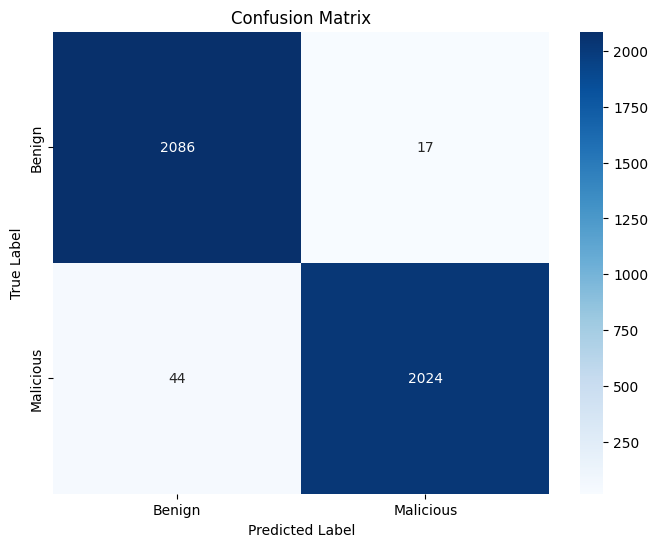

In [23]:
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

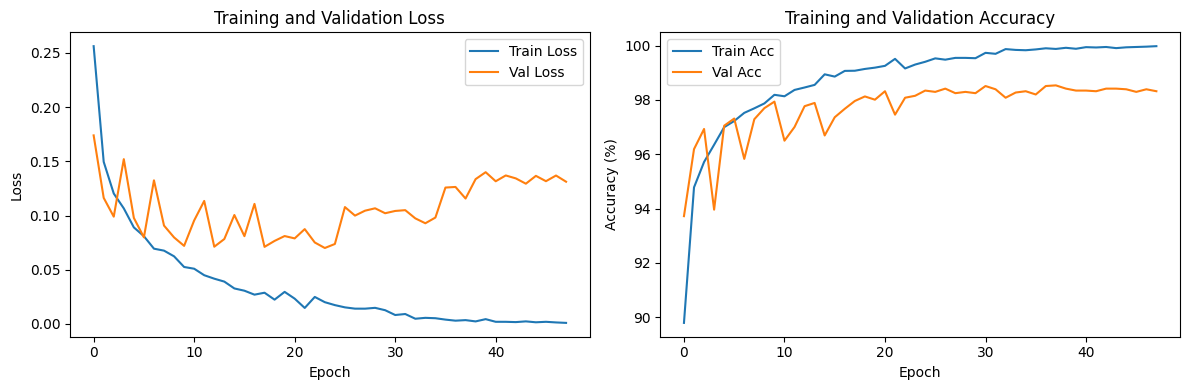


Best Validation Accuracy: 98.54%


In [24]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")

In [25]:
def predict_single_image(model, image_path, transform, device):
    from PIL import Image
    
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor).squeeze()
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0
    
    return prediction, probability

In [27]:
single_image_path = r'/kaggle/input/maldeb-dataset/debinew/Malicious/0002e5e1b878c1b753ba0722713abf309a183a23d5abe871414b9fda9f697fd0.png'

prediction, probability = predict_single_image(model, single_image_path, val_transform, DEVICE)
predicted_class = class_names[prediction]
confidence = probability if prediction == 1 else 1 - probability

print(f"\nSingle Image Prediction:")
print(f"File: {single_image_path}")
print(f"Prediction: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Malicious Probability: {probability*100:.2f}%")


Single Image Prediction:
File: /kaggle/input/maldeb-dataset/debinew/Malicious/0002e5e1b878c1b753ba0722713abf309a183a23d5abe871414b9fda9f697fd0.png
Prediction: Malicious
Confidence: 100.00%
Malicious Probability: 100.00%


In [28]:
single_image_path = r'/kaggle/input/maldeb-dataset/debinew/Benign/000078e2a88d23f8c388cc286218efcf7547fb3ce3f3fe135fe7eefd9950c3c4.png'

prediction, probability = predict_single_image(model, single_image_path, val_transform, DEVICE)
predicted_class = class_names[prediction]
confidence = probability if prediction == 1 else 1 - probability

print(f"\nSingle Image Prediction:")
print(f"File: {single_image_path}")
print(f"Prediction: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Malicious Probability: {probability*100:.2f}%")


Single Image Prediction:
File: /kaggle/input/maldeb-dataset/debinew/Benign/000078e2a88d23f8c388cc286218efcf7547fb3ce3f3fe135fe7eefd9950c3c4.png
Prediction: Benign
Confidence: 100.00%
Malicious Probability: 0.00%
